* Подбор гиперпараметров
* Соблюдение границ пикселей
* Попробовать лосс только на 2 лейблах
* Оформить в архив
* Поощрять сетку оставаться (убрать плато)
* Грид серч у них
* На ночь все параметры
* Докер с гпу
* Против ансамбля

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
with tf.Graph().as_default():
    a = tf.placeholder(tf.float32, None)
    b = tf.placeholder(tf.float32, None)
    
    m = tf.minimum(a, b)
    
    sess = tf.Session()
    print(sess.run([m], feed_dict={a: [1, 2, 3], b: 1})[0])

[ 1.  1.  1.]


In [4]:
DEV_DATASET_CSV = 'dev_dataset.csv'

import csv
import os

import tensorflow as tf
from skimage import io

tf.flags.DEFINE_string(
    'input_dir', 'input_dir', 'Input directory with images.')

tf.flags.DEFINE_string(
    'output_dir', 'output_dir', 'Output directory with images.')

tf.flags.DEFINE_integer(
    'max_epsilon', 15, 'How strong app can change the image')

tf.flags.DEFINE_integer(
    'batch_size', 1, 'How many images process at one time.')

tf.flags.DEFINE_string(
    'checkpoint_path', 'submit/weights/adv_inception_v3.ckpt', 'Path to checkpoint for inception network.')

FLAGS = tf.flags.FLAGS

In [5]:
from skimage import io
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request as urllib
from io import StringIO, BytesIO

from tensorflow.contrib.slim.nets import inception
slim = tf.contrib.slim
%matplotlib inline

In [6]:
import numpy as np
import tensorflow as tf

from tensorflow.contrib import slim
from tensorflow.contrib.slim.nets import inception


class PushinMatyshin:
    def __init__(self, checkpoint_path, batch_size):
        self.batch_size = batch_size
        self.checkpoint_path = checkpoint_path

        self.graph = tf.Graph()
        self.image_shape = (self.batch_size, 299, 299, 3)
        self.num_classes = 1001

        with self.graph.as_default():
            self.real_image = tf.placeholder(tf.float32, self.image_shape, name='real_image')
            self.max_perturbation = tf.placeholder(tf.float32, (), name='max_perturbation')
            
            self.fake_image_subst = tf.Variable(
                np.zeros(self.image_shape, dtype=np.float32), name='fake_image_subst'
            )
            
            self.min_real_image = tf.maximum(0., self.real_image - self.max_perturbation)
            self.max_real_image = tf.minimum(1., self.real_image + self.max_perturbation)
            
            self.fake_image = self.min_real_image + (self.max_real_image - self.min_real_image) * (tf.tanh(self.fake_image_subst) + 1) / 2

            with slim.arg_scope(inception.inception_v3_arg_scope()):
                self.fake_logits, self.inception_end_points = inception.inception_v3(
                    self.fake_image, num_classes=self.num_classes, is_training=False,
                )

            self.softmaxed_fake = tf.nn.softmax(self.fake_logits)
            self.top_classes = tf.nn.top_k(self.softmaxed_fake, 3)

            self.assign_fake_image_subs_by_real = self.fake_image_subst.assign(
                tf.atanh(2 * (self.real_image - self.min_real_image) / (self.max_real_image - self.min_real_image) - 1)
            )

            self.target_probs = tf.placeholder(
                tf.float32, [self.batch_size, self.num_classes], name='target_probs'
            )
            
            self.alpha = tf.placeholder(tf.float32, (), name='alpha')
            self.learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')

#             self.assign_fake_image_subs_by_clipped_fake = self.fake_image_subst.assign(
#                 tf.atanh(
#                     2 * tf.clip_by_value(
#                         self.fake_image, self.min_real_image, self.max_real_image
#                     ) - 1
#                 )
#             )

            self.main_loss = tf.losses.softmax_cross_entropy(
                self.target_probs,
                self.fake_logits,
                label_smoothing=0.1,
                weights=1.0
            )

#             self.abs_img_diff = tf.abs(self.fake_image - self.real_image)
#             self.clipped_img_diff = tf.where(
#                 self.abs_img_diff > self.max_perturbation,
#                 self.abs_img_diff, tf.zeros(self.image_shape)
#             )
#             self.clipped_diff_sum = tf.reduce_sum(self.clipped_img_diff)
#             self.reg_loss = self.alpha * self.clipped_diff_sum

            self.loss = self.main_loss #+ self.reg_loss

            start_vars = set(x.name for x in tf.global_variables())
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)

            self.train = self.optimizer.minimize(self.loss, var_list=[self.fake_image_subst])

            end_vars = tf.global_variables()
            new_vars = [x for x in end_vars if x.name not in start_vars]
            self.init = tf.variables_initializer(var_list=[self.fake_image_subst] + new_vars)

            self.sess = tf.Session()
            saver = tf.train.Saver(slim.get_model_variables())
            saver.restore(self.sess, self.checkpoint_path)


    def inference(self, images, targets, max_perturbation, alpha=1, start_lr=0.1, end_lr=0.01, n=10):
        def clip_fake(real_image, max_perturbation):
            self.sess.run(
                [self.assign_fake_image_subs_by_clipped_fake], feed_dict={
                    self.max_perturbation: max_perturbation,
                    self.real_image: real_image,
                }
            )

        target_probs = np.zeros((len(targets), self.num_classes))
        max_perturbation /= 255
        images = np.array(images) / 255

        learning_rate = start_lr

        for number, target in enumerate(targets):
            target_probs[number][target] = 1

        with self.graph.as_default():
            self.sess.run(self.init)
            result_images = self.sess.run(
                [self.assign_fake_image_subs_by_real], feed_dict={
                    self.real_image: images,
                    self.max_perturbation: max_perturbation,
                }
            )

            for i in range(n):
                # clip_fake(images, max_perturbation)
                result_images, loss, softmaxed, fake_logits, top_classes, _ = self.sess.run(
                    [self.fake_image, self.loss, self.softmaxed_fake, self.fake_logits,
                     self.top_classes, self.train],
                    feed_dict={
                        self.real_image: images,
                        self.target_probs: target_probs,
                        self.max_perturbation: max_perturbation,
                        self.alpha: alpha,
                        self.learning_rate: learning_rate,
                    }
                )
                print(
                    'Step: {step} | Loss: {loss} | Learning rate: {learning_rate}'.format(
                        step=i,
                        loss=loss,
                        learning_rate=learning_rate,
                    )
                )
                print(top_classes)
                learning_rate *= (end_lr / start_lr) ** (1 / n)

            # clip_fake(images, max_perturbation)
            return np.round(result_images * 255).astype(np.uint8) #, loss


In [7]:
def get_batches(folder_path, batch_size):
    images_batch = []
    targets_batch = []
    names_batch = []

    with open(os.path.join(folder_path, 'target_class.csv'), 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) == 0:
                break

            file_name, target = row[0], int(row[1])

            file_path = os.path.join(folder_path, file_name)

            names_batch.append(file_name)
            images_batch.append(io.imread(file_path))
            targets_batch.append(target)

            if len(images_batch) == batch_size:
                yield names_batch, images_batch, targets_batch, batch_size
                names_batch, images_batch, targets_batch = [], [], []

        if len(images_batch) > 0:
            last_name = names_batch[-1]
            last_image = images_batch[-1]
            last_target = targets_batch[-1]

            enter_len = len(names_batch)
            extra_len = batch_size - enter_len

            names_batch.extend([last_name] * extra_len)
            images_batch.extend([last_image] * extra_len)
            targets_batch.extend([last_target] * extra_len)

            yield names_batch, images_batch, targets_batch, enter_len


def save_images(folder_path, names, images, real_len):
    for n, (image, name) in enumerate(zip(images, names)):
        if n == real_len:
            break
        img_path = os.path.join(folder_path, name)
        io.imsave(img_path, image)


def main(_):
    pm = PushinMatyshin(FLAGS.checkpoint_path, FLAGS.batch_size)

    for names_batch, images_batch, targets_batch, real_len in get_batches(FLAGS.input_dir, FLAGS.batch_size):
        images = pm.inference(
            images_batch, targets_batch,
            max_perturbation=FLAGS.max_epsilon, alpha=1, start_lr=0.05, end_lr=0.001, n=10
        )
        save_images(FLAGS.output_dir, names_batch, images, real_len)


In [8]:
pm = PushinMatyshin(FLAGS.checkpoint_path, FLAGS.batch_size)

INFO:tensorflow:Restoring parameters from submit/weights/adv_inception_v3.ckpt


In [9]:
df = pd.read_csv(DEV_DATASET_CSV)
df.head(5)

,ImageId,URL,x1,y1,x2,y2,TrueLabel,TargetClass,OriginalLandingURL,License,Author,AuthorProfileURL
0,0c7ac4a8c9dfa802,https://c1.staticflickr.com/9/8540/28821627444...,0.000000,0.0,0.871838,1.000000,306,779,https://www.flickr.com/photos/gails_pictures/2...,https://creativecommons.org/licenses/by/2.0/,gailhampshire,https://www.flickr.com/people/gails_pictures/
1,f43fbfe8a9ea876c,https://c1.staticflickr.com/9/8066/28892033183...,0.250000,0.0,1.000000,0.599758,884,378,https://www.flickr.com/photos/barty/28892033183,https://creativecommons.org/licenses/by/2.0/,Barry Badcock,https://www.flickr.com/people/barty/
2,4fc263d35a3ad3ee,https://c1.staticflickr.com/8/7378/27465801596...,0.333333,0.0,1.000000,1.000000,244,123,https://www.flickr.com/photos/foxcroftacademy/...,https://creativecommons.org/licenses/by/2.0/,Foxcroft Academy,https://www.flickr.com/people/foxcroftacademy/
3,cc13c2bc5cdd1f44,https://c1.staticflickr.com/9/8864/28546467522...,0.000000,0.0,0.500000,0.750000,560,741,https://www.flickr.com/photos/o_0/28546467522/,https://creativecommons.org/licenses/by/2.0/,Guilhem Vellut,https://www.flickr.com/people/o_0/
4,73a52afd2f818ed5,https://c1.staticflickr.com/6/5607/31066602702...,0.489195,0.0,1.000000,0.750000,439,696,https://www.flickr.com/photos/chemiebw/3106660...,https://creativecommons.org/licenses/by/2.0/,Chemie-Verb\303\244nde Baden-W\303\274rttemberg,https://www.flickr.com/people/chemiebw/


In [10]:
def make_filename(img_id):
    filename = img_id + '.png'
    print(filename)
    return filename

def make_filepath(img_id):
    return os.path.join(FLAGS.input_dir, make_filename(img_id))

def open_img(img_id):
    filepath = make_filepath(img_id)
    return io.imread(filepath)

def get_image_and_target(num):
    line = df.ix[num]
    
    url = line['URL']
    img_id = line['ImageId']
    
    return open_img(img_id), line['TargetClass'], line['TrueLabel']

In [11]:
img, target, label = get_image_and_target(101)
label, target

7a85f42383ec2f81.png


(709, 802)

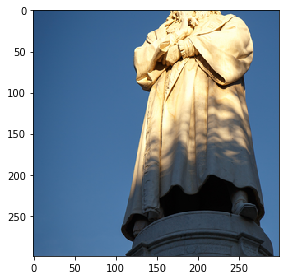

In [12]:
io.imshow(img)

In [13]:
images = pm.inference(
    [img], [target],
    max_perturbation=50, alpha=1, start_lr=0.1, end_lr=0.001, n=10
)

Step: 0 | Loss: 10.942798614501953 | Learning rate: 0.1
TopKV2(values=array([[ 0.90789211,  0.0227431 ,  0.00343417]], dtype=float32), indices=array([[709, 683, 669]], dtype=int32))
Step: 1 | Loss: 11.036605834960938 | Learning rate: 0.06309573444801933
TopKV2(values=array([[ 0.92258674,  0.0141949 ,  0.00198537]], dtype=float32), indices=array([[709, 683, 874]], dtype=int32))
Step: 2 | Loss: 7.128985404968262 | Learning rate: 0.03981071705534973
TopKV2(values=array([[ 0.04075736,  0.03352295,  0.02524791]], dtype=float32), indices=array([[864, 709, 569]], dtype=int32))
Step: 3 | Loss: 4.902307987213135 | Learning rate: 0.0251188643150958
TopKV2(values=array([[ 0.07185136,  0.04565567,  0.03732612]], dtype=float32), indices=array([[843, 776, 864]], dtype=int32))
Step: 4 | Loss: 2.214710235595703 | Learning rate: 0.015848931924611134
TopKV2(values=array([[ 0.24318478,  0.21719941,  0.04895712]], dtype=float32), indices=array([[843, 802, 434]], dtype=int32))
Step: 5 | Loss: 1.11229932308

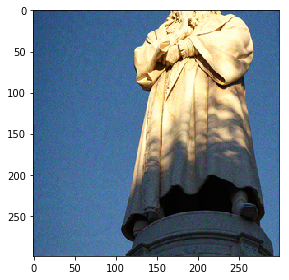

In [14]:
io.imshow(images[0] / 255)

In [6]:
i = get_batches('input_dir', 1)

In [7]:
names_batch, images_batch, targets_batch, enter_len = next(i)
targets_batch

[1]

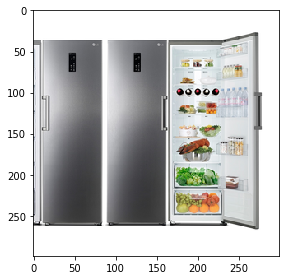

In [8]:
io.imshow(images_batch[0])
targets_batch = [500]

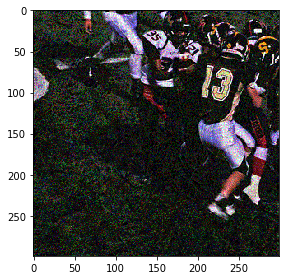

In [28]:
io.imshow(images[0])

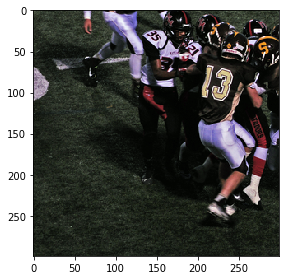

In [29]:
io.imshow(images_batch[0])

In [15]:
np.max(images[0] - images_batch[0])

255

In [2]:
tf.flags.DEFINE_string(
    'master', '', 'The address of the TensorFlow master to use.'
)

tf.flags.DEFINE_string(
    'checkpoint_path', 'submit/weights/adv_inception_v3.ckpt', 'Path to checkpoint for inception network.')

tf.flags.DEFINE_string(
    'input_dir', 'input_dir', 'Input directory with images.')

tf.flags.DEFINE_string(
    'output_dir', 'output_dir', 'Output directory with images.')

tf.flags.DEFINE_integer(
    'batch_size', 1, 'How many images process at one time.')

FLAGS = tf.flags.FLAGS

In [28]:
DEV_DATASET_CSV = 'dev_dataset.csv'

In [29]:
df = pd.read_csv(DEV_DATASET_CSV)
df.head(5)

,ImageId,URL,x1,y1,x2,y2,TrueLabel,TargetClass,OriginalLandingURL,License,Author,AuthorProfileURL
0,0c7ac4a8c9dfa802,https://c1.staticflickr.com/9/8540/28821627444...,0.000000,0.0,0.871838,1.000000,306,779,https://www.flickr.com/photos/gails_pictures/2...,https://creativecommons.org/licenses/by/2.0/,gailhampshire,https://www.flickr.com/people/gails_pictures/
1,f43fbfe8a9ea876c,https://c1.staticflickr.com/9/8066/28892033183...,0.250000,0.0,1.000000,0.599758,884,378,https://www.flickr.com/photos/barty/28892033183,https://creativecommons.org/licenses/by/2.0/,Barry Badcock,https://www.flickr.com/people/barty/
2,4fc263d35a3ad3ee,https://c1.staticflickr.com/8/7378/27465801596...,0.333333,0.0,1.000000,1.000000,244,123,https://www.flickr.com/photos/foxcroftacademy/...,https://creativecommons.org/licenses/by/2.0/,Foxcroft Academy,https://www.flickr.com/people/foxcroftacademy/
3,cc13c2bc5cdd1f44,https://c1.staticflickr.com/9/8864/28546467522...,0.000000,0.0,0.500000,0.750000,560,741,https://www.flickr.com/photos/o_0/28546467522/,https://creativecommons.org/licenses/by/2.0/,Guilhem Vellut,https://www.flickr.com/people/o_0/
4,73a52afd2f818ed5,https://c1.staticflickr.com/6/5607/31066602702...,0.489195,0.0,1.000000,0.750000,439,696,https://www.flickr.com/photos/chemiebw/3106660...,https://creativecommons.org/licenses/by/2.0/,Chemie-Verb\303\244nde Baden-W\303\274rttemberg,https://www.flickr.com/people/chemiebw/


In [30]:
def make_filename(img_id):
    filename = img_id + '.png'
    print(filename)
    return filename

def make_filepath(img_id):
    return os.path.join(FLAGS.input_dir, make_filename(img_id))

def open_img(img_id):
    filepath = make_filepath(img_id)
    return io.imread(filepath)

def get_image_and_target(num):
    line = df.ix[num]
    
    url = line['URL']
    img_id = line['ImageId']
    
    return open_img(img_id) / 255, line['TargetClass'], line['TrueLabel']

In [31]:
img, target, label = get_image_and_target(101)

7a85f42383ec2f81.png


In [32]:
target, label

(802, 709)

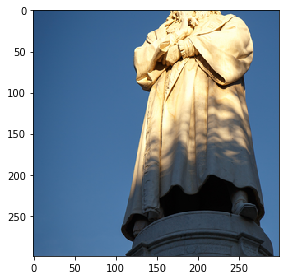

In [33]:
io.imshow(img)

In [17]:
target

NameError: name 'target' is not defined

In [22]:
class PushinMatyshin:
    def __init__(self):
        self.graph = tf.Graph()
        self.image_shape = (FLAGS.batch_size, 299, 299, 3)
        self.num_classes = 1001
        
        with self.graph.as_default():
            self.fake_image_subst = tf.Variable(
                np.zeros(self.image_shape, dtype=np.float32), name='fake_image_subst'
            )
            self.fake_image = (tf.tanh(self.fake_image_subst) + 1) / 2
        
            with slim.arg_scope(inception.inception_v3_arg_scope()):
                self.fake_logits, self.inception_end_points = inception.inception_v3(
                    self.fake_image, num_classes=self.num_classes, is_training=False,
                )
                
            self.softmaxed_fake = tf.nn.softmax(self.fake_logits)
            self.top_classes = tf.nn.top_k(self.softmaxed_fake, 3)
        
            self.real_image = tf.placeholder(tf.float32, self.image_shape, name='real_image')
            
            self.assign_fake_image_subs_by_real = self.fake_image_subst.assign(
                tf.atanh(2 * self.real_image - 1)
            )

            self.target_probs = tf.placeholder(
                tf.float32, [FLAGS.batch_size, self.num_classes], name='target_probs'
            )
            self.max_perturbation = tf.placeholder(tf.float32, (), name='max_perturbation')
            self.alpha = tf.placeholder(tf.float32, (), name='alpha')
            self.learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')

            self.main_loss = tf.losses.softmax_cross_entropy(
                self.target_probs,
                self.fake_logits,
                label_smoothing=0.1,
                weights=1.0
            )

            self.loss = self.main_loss # + self.reg_loss

            start_vars = set(x.name for x in tf.global_variables())
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            
            self.train = self.optimizer.minimize(self.loss, var_list=[self.fake_image_subst])
            
            end_vars = tf.global_variables()
            new_vars = [x for x in end_vars if x.name not in start_vars]
            self.init = tf.variables_initializer(var_list=[self.fake_image_subst] + new_vars)

            self.sess = tf.Session()
            saver = tf.train.Saver(slim.get_model_variables())
            saver.restore(self.sess, FLAGS.checkpoint_path)
    
    def inference(self, images, targets, max_perturbation=15, alpha=1, start_lr=0.1, end_lr=0.01, n=10):
        def clip_fake(real_image, max_perturbation):
            self.sess.run(
                [self.assign_fake_image_subs_by_clipped_fake], feed_dict={
                    self.max_perturbation: max_perturbation,
                    self.real_image: real_image,
                }
            )
        
        target_probs = np.zeros((len(targets), self.num_classes))
        max_perturbation /= 255
        
        learning_rate = start_lr
        
        for number, target in enumerate(targets):
            target_probs[number][target] = 1
        
        with self.graph.as_default():
            self.sess.run(self.init)
            result_images = self.sess.run(
                [self.assign_fake_image_subs_by_real], feed_dict={self.real_image: images}
            )

            for i in range(n):
                result_images, loss, main_loss, softmaxed, fake_logits, top_classes, _ = self.sess.run(
                    [self.fake_image, self.loss, self.main_loss, self.softmaxed_fake, self.fake_logits, self.top_classes, self.train],
                    feed_dict={
                        self.real_image: images,
                        self.target_probs: target_probs,
                        self.max_perturbation: max_perturbation,
                        self.alpha: alpha,
                        self.learning_rate: learning_rate,
                    }
                )
                print(
                    'Step: {step} | Loss: {loss}, Mainloss: {main_loss} | Learning rate: {learning_rate}'.format(
                        step=i,
                        loss=loss,
                        main_loss=main_loss,
                        learning_rate=learning_rate,
                    )
                )
                print(top_classes)
                learning_rate *= (end_lr / start_lr) ** (1/n)
                
            clip_fake(images, max_perturbation)
            return result_images, loss

In [23]:
pm = PushinMatyshin()

INFO:tensorflow:Restoring parameters from submit/weights/adv_inception_v3.ckpt


In [24]:
img, target, label = get_image_and_target(0)
print(target, label)
result, loss = pm.inference([img], [target], max_perturbation=4, alpha=1, start_lr=0.05, end_lr=0.001, n=20)

NameError: name 'get_image_and_target' is not defined

In [13]:
result, loss = pm.inference(images_batch, targets_batch, max_perturbation=4, alpha=1, start_lr=0.05, end_lr=0.001, n=20)

Step: 0 | Loss: nan, Mainloss: nan, Reg loss: 0.0 | Learning rate: 0.05
TopKV2(values=array([[ nan,  nan,  nan]], dtype=float32), indices=array([[0, 1, 2]], dtype=int32))
Step: 1 | Loss: nan, Mainloss: nan, Reg loss: 0.0 | Learning rate: 0.04111700797134446
TopKV2(values=array([[ nan,  nan,  nan]], dtype=float32), indices=array([[0, 1, 2]], dtype=int32))
Step: 2 | Loss: nan, Mainloss: nan, Reg loss: 0.0 | Learning rate: 0.03381216689031207
TopKV2(values=array([[ nan,  nan,  nan]], dtype=float32), indices=array([[0, 1, 2]], dtype=int32))
Step: 3 | Loss: nan, Mainloss: nan, Reg loss: 0.0 | Learning rate: 0.02780510271114781
TopKV2(values=array([[ nan,  nan,  nan]], dtype=float32), indices=array([[0, 1, 2]], dtype=int32))


KeyboardInterrupt: 

In [85]:
img_b = (np.round(img * 255)).astype(np.int)
result_b = (np.round(result * 255)).astype(np.int)

In [86]:
np.max(img_b - result_b[0])

4

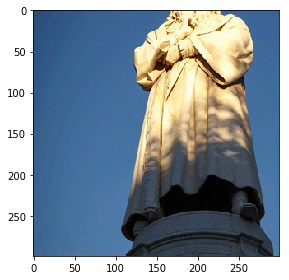

In [87]:
io.imshow(result[0])

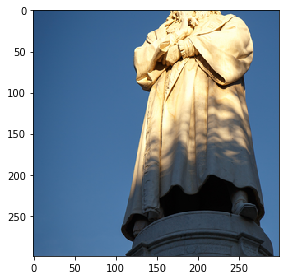

In [88]:
io.imshow(img)